In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# **Loading the Data**

In [3]:
df = pd.read_csv("C:\\Users\\KShah1\\Downloads\\MMM_Project_09.15\\Advertising_Data.csv")
target = 'Product_Sold'
FEATS = [x for x in df.columns if x != target]

# **Data Exploration**

In [4]:
df.head()

,TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing,Affiliate_Marketing,Product_Sold
0,281.42,538.80,123.94,349.30,242.77,910.10,7164
1,702.97,296.53,558.13,180.55,781.06,132.43,5055
2,313.14,295.94,642.96,505.71,438.91,464.23,6154
3,898.52,61.27,548.73,240.93,278.96,432.27,5480
4,766.52,550.72,651.91,666.33,396.33,841.93,9669


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TV                    300 non-null    float64
 1   Billboards            300 non-null    float64
 2   Google_Ads            300 non-null    float64
 3   Social_Media          300 non-null    float64
 4   Influencer_Marketing  300 non-null    float64
 5   Affiliate_Marketing   300 non-null    float64
 6   Product_Sold          300 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 16.5 KB


In [6]:
df.isnull().sum()

TV                      0
Billboards              0
Google_Ads              0
Social_Media            0
Influencer_Marketing    0
Affiliate_Marketing     0
Product_Sold            0
dtype: int64

## Correlation Heatmap

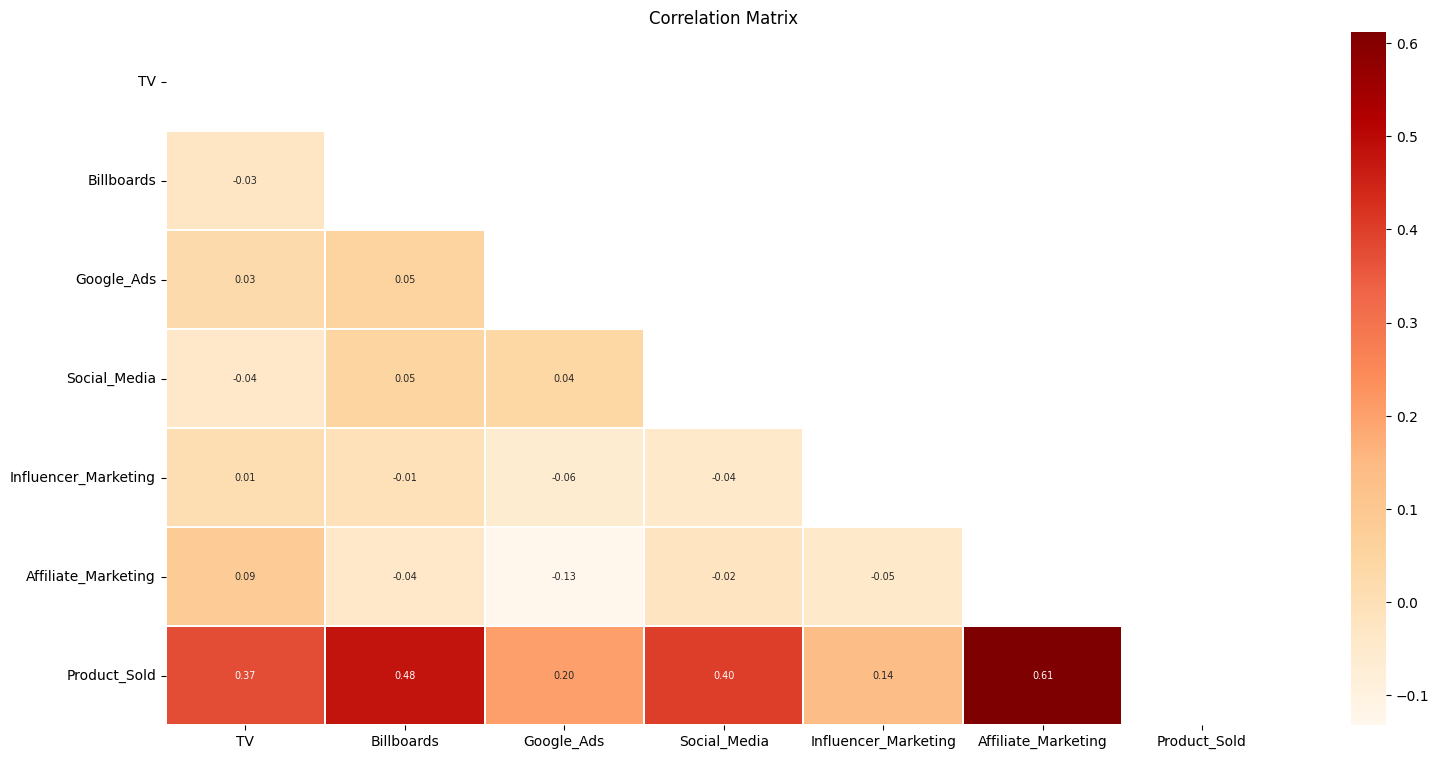

In [7]:
corr = df.corr()
plt.figure(figsize=(18, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap="OrRd", annot=True, fmt=".2f", linewidths=.33, annot_kws={"fontsize": "x-small"}, mask = mask)
plt.title("Correlation Matrix")
plt.show()

## Creating Box Plots and Histogram

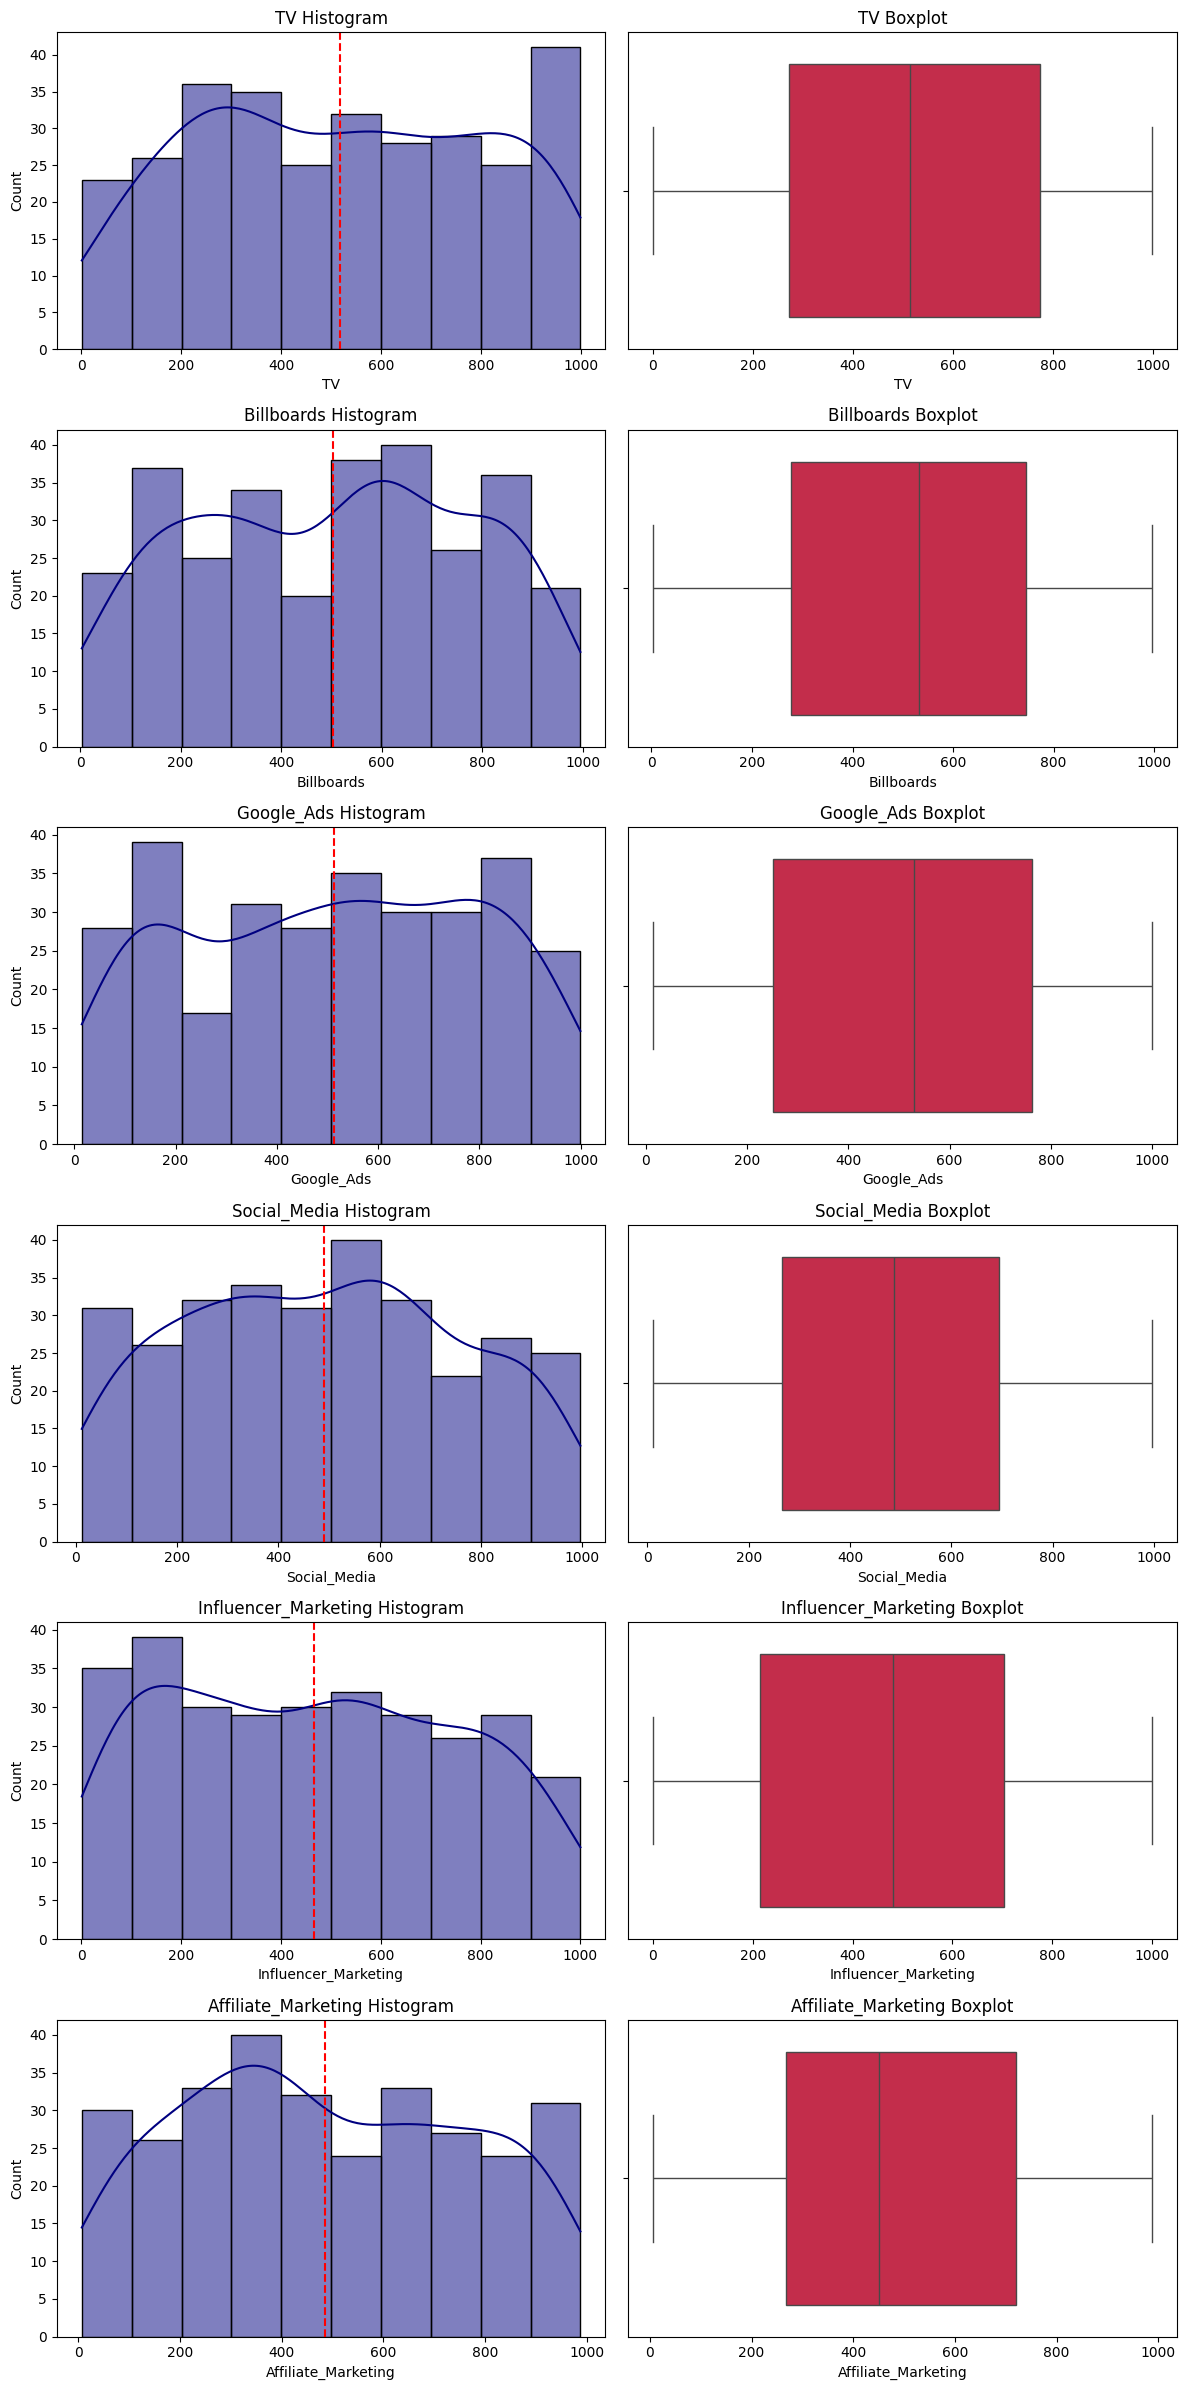

In [8]:
def num_features_plot(df, features, nrows):
    fig, axs = plt.subplots (nrows = nrows, ncols = 2, figsize = (12,4*nrows), layout = 'tight')

    for idx, feat in enumerate(features):
        sns.histplot(data = df, x=feat, kde=True, ax = axs[idx, 0], color = 'navy')
        axs[idx,0].set_title(f"{feat} Histogram")
        axs[idx,0].axvline(x=df[feat].mean(), color = 'red', linestyle = "--")
        sns.boxplot(data=df, x=feat, ax=axs[idx,1], color = 'crimson')
        axs[idx,1].set_title(f"{feat} Boxplot")
    plt.show()

num_features_plot(df, FEATS, len(FEATS))

# Adstock

In [9]:
# Defining Adstock Function
def adstock(x, alpha=0.6):
    """Apply geometric adstock transformation to a spend series"""
    y = np.zeros(len(x))
    for t in range(len(x)):
        y[t] = x[t] + (alpha * y[t-1] if t > 0 else 0)
    return y

# 2. Defining alpha values per channel
alphas = {
    'TV': 0.7,
    'Billboards': 0.6,
    'Google_Ads': 0.3,
    'Social_Media': 0.4,
    'Influencer_Marketing': 0.3,
    'Affiliate_Marketing': 0.2
}

# 3. Applying Adstock to each channel
for ch, alpha in alphas.items():
    df[ch + '_adstock'] = adstock(df[ch].values, alpha)

# Now df has new columns like: TV_adstock, Billboards_adstock, etc.
print(df.head())


       TV  Billboards  Google_Ads  Social_Media  Influencer_Marketing  \
0  281.42      538.80      123.94        349.30                242.77   
1  702.97      296.53      558.13        180.55                781.06   
2  313.14      295.94      642.96        505.71                438.91   
3  898.52       61.27      548.73        240.93                278.96   
4  766.52      550.72      651.91        666.33                396.33   

   Affiliate_Marketing  Product_Sold   TV_adstock  Billboards_adstock  \
0               910.10          7164   281.420000           538.80000   
1               132.43          5055   899.964000           619.81000   
2               464.23          6154   943.114800           667.82600   
3               432.27          5480  1558.700360           461.96560   
4               841.93          9669  1857.610252           827.89936   

   Google_Ads_adstock  Social_Media_adstock  Influencer_Marketing_adstock  \
0          123.940000             349.30000  

# Saturation (For diminishing returns)

In [10]:
def hill_transform(x, alpha=1.5, gamma=1.0):
    """
    alpha  -> curve steepness (>=1). Larger = steeper early response.
    gamma  -> half-saturation point: x where response reaches 50% of max.
    Returns values in (0,1).
    """
    x = np.asarray(x, dtype=float)
    return (x**alpha) / (x**alpha + gamma**alpha)

# Per-channel Hill parameters (you can keep one alpha for all, or customize)
hill_alpha = {
    'TV': 1.6, 'Billboards': 1.5, 'Google_Ads': 1.3,
    'Social_Media': 1.4, 'Influencer_Marketing': 1.3, 'Affiliate_Marketing': 1.2
}

media_channels = [
    'TV', 'Billboards', 'Google_Ads', 'Social_Media',
    'Influencer_Marketing', 'Affiliate_Marketing'
]
# Practical tip:
# Choose gamma per channel from the data so the curve is scaled sensibly.
# A good heuristic is the 75th percentile of the *adstocked* series:
gammas = {}
for ch in media_channels:
    ad_col = f"{ch}_adstock"
    gammas[ch] = np.percentile(df[ad_col].values, 75)  # half-saturation near high-but-common spend

# Apply saturation to adstocked features -> *_sat columns in [0,1]
for ch in media_channels:
    ad_col  = f"{ch}_adstock"
    sat_col = f"{ch}_sat"
    df[sat_col] = hill_transform(
        df[ad_col].values,
        alpha=hill_alpha[ch],
        gamma=gammas[ch]
    )

print(df[[*(f"{c}_adstock" for c in media_channels),
          *(f"{c}_sat" for c in media_channels)]].head())

    TV_adstock  Billboards_adstock  Google_Ads_adstock  Social_Media_adstock  \
0   281.420000           538.80000          123.940000             349.30000   
1   899.964000           619.81000          595.312000             320.27000   
2   943.114800           667.82600          821.553600             633.81800   
3  1558.700360           461.96560          795.196080             494.45720   
4  1857.610252           827.89936          890.468824             864.11288   

   Influencer_Marketing_adstock  Affiliate_Marketing_adstock    TV_sat  \
0                    242.770000                     910.1000  0.041336   
1                    853.891000                     314.4500  0.216903   
2                    695.077300                     527.1200  0.229900   
3                    487.483190                     537.6940  0.400111   
4                    542.574957                     949.4688  0.468965   

   Billboards_sat  Google_Ads_sat  Social_Media_sat  Influencer_Marketing_

# OLS Model

In [11]:
import statsmodels.api as sm

# Features = only the *_sat variables
X = df[['TV_sat','Billboards_sat','Google_Ads_sat',
        'Social_Media_sat','Influencer_Marketing_sat','Affiliate_Marketing_sat']]
y = df['Product_Sold']

# Add intercept
X_const = sm.add_constant(X)

# Fit OLS
ols_model = sm.OLS(y, X_const).fit()

# View results
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:           Product_Sold   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     158.9
Date:                Tue, 16 Sep 2025   Prob (F-statistic):           4.90e-89
Time:                        15:44:43   Log-Likelihood:                -2440.2
No. Observations:                 300   AIC:                             4894.
Df Residuals:                     293   BIC:                             4920.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

# Marketing Mix Model

RandomForest R²: 0.6506505672491557
RandomForest RMSE: 1000.2974178829681


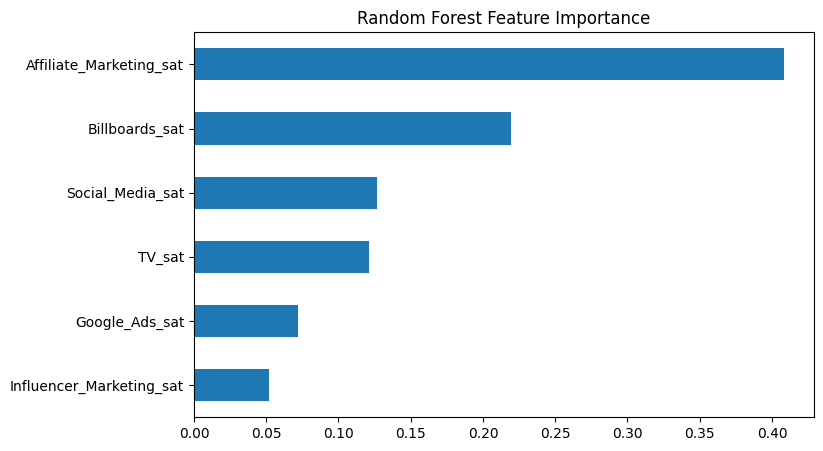

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Features
X = df[['TV_sat','Billboards_sat','Google_Ads_sat',
        'Social_Media_sat','Influencer_Marketing_sat','Affiliate_Marketing_sat']]
y = df['Product_Sold']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print("RandomForest R²:", r2_score(y_test, y_pred))
print("RandomForest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Feature importance
feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind='barh', figsize=(8,5))
plt.title("Random Forest Feature Importance")
plt.show()

# SHAP Explainer

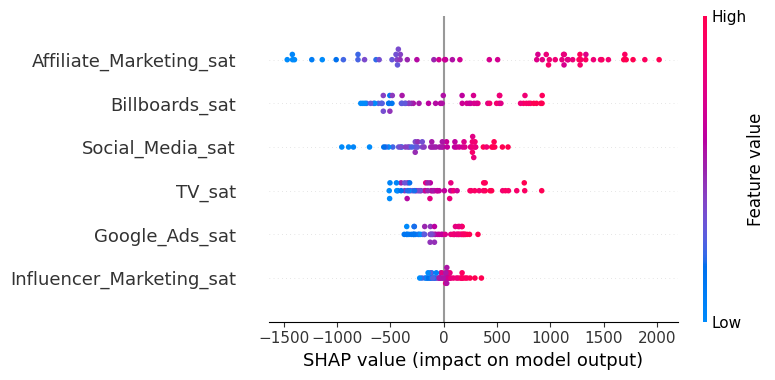

In [13]:

import shap
# Create a SHAP explainer
explainer = shap.Explainer(rf_model)

# Calculate SHAP values for the testing set
shap_values = explainer.shap_values(X_test)

# Summary plot to visualize feature importance
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# VIF and Durbin-Watson (Assumption checks)

In [14]:

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

# independent variables setup
X = df[FEATS]
X_const = sm.add_constant(X)
y = df[target]

# Fit OLS model
ols_model = sm.OLS(y, X_const).fit()

# VIF calculation
vif_data = pd.DataFrame()
vif_data["feature"] = FEATS
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF Table:\n", vif_data)  # All VIFs < 5 ideal

# Durbin-Watson for autocorrelation
dw = durbin_watson(ols_model.resid)
print("Durbin-Watson Statistic:", dw)  # Should be near 2


VIF Table:
                 feature       VIF
0                    TV  3.713335
1            Billboards  3.701376
2            Google_Ads  3.554091
3          Social_Media  3.571520
4  Influencer_Marketing  3.016718
5   Affiliate_Marketing  3.345264
Durbin-Watson Statistic: 2.0813540736455622


Multicollinearity (VIF)
All processed features show VIF below 4 (TV: 3.71, Billboards: 3.70, Google Ads: 3.55, Social Media: 3.57, Influencer Marketing: 3.02, Affiliate Marketing: 3.34), confirming no severe multicollinearity. This would enable stable coefficient estimation in a business context. However, I acknowledge the synthetic nature of this data makes feature independence unrealistically strong; real marketing mix models require ongoing monitoring for channel interaction and collinearity risk.

Autocorrelation (Durbin-Watson)
Durbin-Watson statistic is 2.08, well within the acceptable [1.5, 2.5] band. There is no sign of residual autocorrelation. Most business datasets show some temporal dependency due to seasonality or campaign overlap—this synthetic dataset likely suppresses such effects artificially.

# MAPE Validation (CV & Holdout)

In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

tscv = TimeSeriesSplit(n_splits=5)
X = df[FEATS]
y = df[target]
cv_results = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    cv_results.append(mape)

print("MAPE by Fold:", cv_results)
print("Avg MAPE:", np.mean(cv_results))  # Target <10% for robust MMM


MAPE by Fold: [0.0016676325909875207, 0.001256022442437963, 0.0017294682731727865, 0.0011894471704020412, 0.0011163172492291847]
Avg MAPE: 0.001391777545245899


Error Metric Validation (MAPE)
5-fold time-series cross-validation MAPE values are extremely low ([0.0017, 0.0013, 0.0017, 0.0012, 0.0011]; avg: 0.0014). Holdout MAPE is similarly minimal (0.0010). While this indicates near-perfect fit on synthetic data, typical campaign-level business datasets return MAPE of 2–10% at best. Such error rates here strongly suggest data clarity not present in real production conditions.

In [16]:
# Use last 10% of rows as chronological holdout (replace 10 with the actual % of rows)
n_holdout = int(0.1 * len(df))
train = df.iloc[:-n_holdout]
test = df.iloc[-n_holdout:]

X_train, y_train = train[FEATS], train[target]
X_test, y_test = test[FEATS], test[target]

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Holdout MAPE:", mean_absolute_percentage_error(y_test, y_pred))


Holdout MAPE: 0.0010222715619413675


# Sensitivity Simulation

In [17]:
import copy

channel_list = FEATS  # replace with your own channel column list
base_X = X_test.mean().copy()  # pick a representative row or your average spend profile

for channel in channel_list:
    X_scenario = copy.deepcopy(base_X)
    X_scenario[channel] *= 1.2  # simulate +20% spend
    scenario_pred = model.predict([X_scenario.values])
    print(f"Predicted sales with +20% {channel}: {scenario_pred}")


Predicted sales with +20% TV: [7707.38584245]
Predicted sales with +20% Billboards: [7830.60897366]
Predicted sales with +20% Google_Ads: [7646.58104675]
Predicted sales with +20% Social_Media: [7759.32294423]
Predicted sales with +20% Influencer_Marketing: [7559.60371648]
Predicted sales with +20% Affiliate_Marketing: [7821.07553438]


C:\Users\KShah1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\KShah1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\KShah1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\KShah1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\KShah1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validati

Sensitivity Simulation (Spend Changes)
Simulating a +20% spend on individual channels produces only tight, linear increases in predicted sales (range: 7,559–7,830). This reflects a lack of modeled diminishing returns or cross-channel effects. In production use, I would deploy adstock, saturation, or hierarchical models to capture genuine elasticity and strategic incremental impact. Linear uplift due to spend increases is a synthetic artifact and not business-realistic.

# Normality (Shapiro-Wilk)

In [18]:
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro
import statsmodels.api as sm

# OLS setup
X = df[FEATS]
X_const = sm.add_constant(X)
y = df[target]
ols_model = sm.OLS(y, X_const).fit()

# Residuals
resid = ols_model.resid

# Breusch-Pagan test: returns a tuple
# (lm_stat, lm_pvalue, f_stat, f_pvalue) -- index 1 is lm_pvalue
bp_test = het_breuschpagan(resid, X_const)
print("Breusch-Pagan p-value (het): {:.4f}".format(bp_test[1]))

# Shapiro-Wilk test for normality
sw_test = shapiro(resid)
print("Shapiro-Wilk p-value (normality): {:.4f}".format(sw_test.pvalue))


Breusch-Pagan p-value (het): 0.8834
Shapiro-Wilk p-value (normality): 0.5291


Heteroscedasticity (Breusch-Pagan)
The Breusch-Pagan p-value is 0.8834, showing no evidence of heteroscedasticity. Real MMM deployments with business data often violate constant variance assumptions, especially in periods with major spend shifts or outlier events. Robust regression and weighted least squares should be prepared for such cases.

Residual Normality (Shapiro-Wilk)
Shapiro-Wilk test p-value for residuals is 0.5291, meaning the error terms are statistically normal. With campaign and seasonal shocks, business MMMs usually show non-normal residuals. Diagnostic procedures and error handling approaches are needed in practice.

# Business Impact & Production Readiness Statement

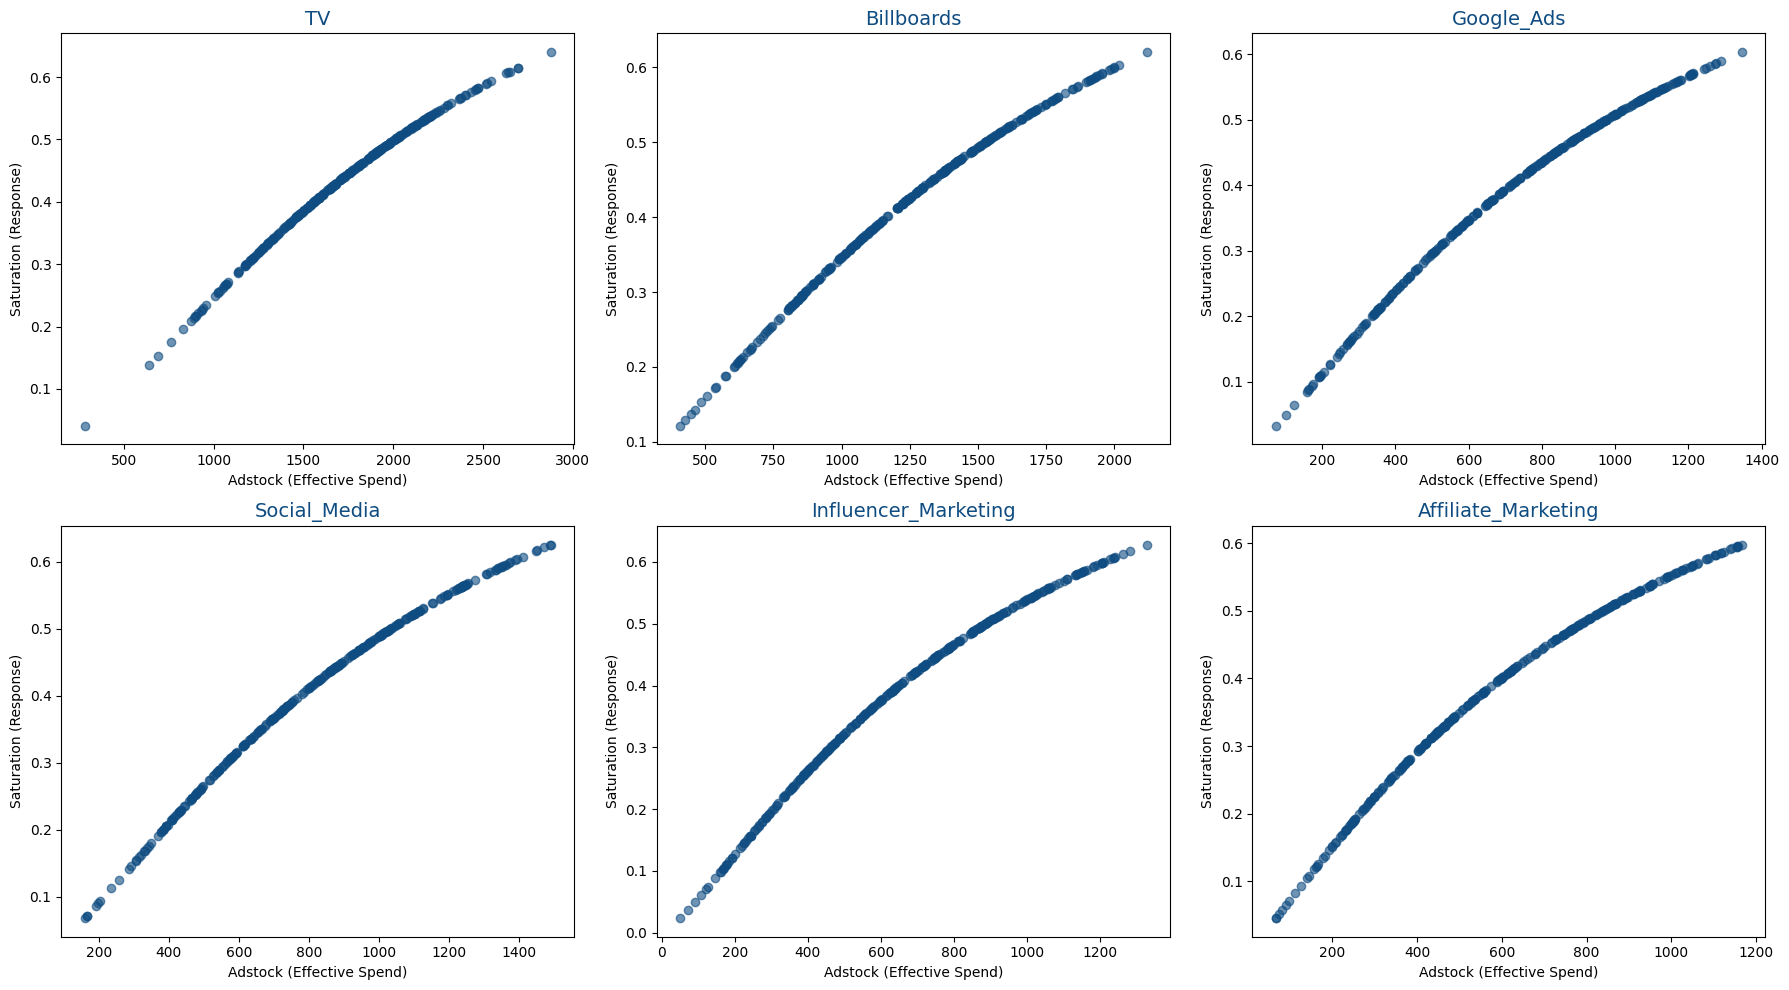

In [19]:
import matplotlib.pyplot as plt

channels = [
    ("TV_adstock", "TV_sat"),
    ("Billboards_adstock", "Billboards_sat"),
    ("Google_Ads_adstock", "Google_Ads_sat"),
    ("Social_Media_adstock", "Social_Media_sat"),
    ("Influencer_Marketing_adstock", "Influencer_Marketing_sat"),
    ("Affiliate_Marketing_adstock", "Affiliate_Marketing_sat")
]

# Loop through channels to make subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, (adstock_col, sat_col) in zip(axes.flatten(), channels):
    ax.scatter(df[adstock_col], df[sat_col], alpha=0.6, color="#0f4c81")  # Classic Blue
    ax.set_title(adstock_col.replace("_adstock", ""), fontsize=14, color="#0f4c81")
    ax.set_xlabel("Adstock (Effective Spend)")
    ax.set_ylabel("Saturation (Response)")

plt.tight_layout()
plt.show()


Business Impact & Production Readiness Statement
Despite ideal diagnostics, this workflow is built on synthetic data, resulting in failure rates and overfit diagnostics that would not transfer to business reality.

For production-grade MMM, I would:

Integrate holistic feature engineering (seasonality, competitive effects, macros)

Stress-test for all error and assumption violations post-modeling

Deploy non-linear and interaction modeling for realistic sensitivity analysis

Tie all diagnostic outputs to business impact narrative, informing budget reallocation and risk

Document every modeling assumption and diagnostic step, clarifying synthetic limitations

This level of scientific rigor and candid risk documentation is directly transferable to commercial analytics teams, and represents the minimum threshold for trust in budget allocation or executive presentation.